<a href="https://colab.research.google.com/github/Modequick/Machine-Learning-Project/blob/main/Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
from sklearn.cluster import KMeans

In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
df=pd.read_csv("/content/drive/MyDrive/Skripsi/Change_Accom_Behavior_Hashed 2.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Improving Data Logic


In [162]:
df["sales_date_utc7"] = pd.to_datetime(df["sales_date_utc7"])
df["sales_timestamp"] = pd.to_datetime(df["sales_timestamp"])
df["check_in_date"] = pd.to_datetime(df["check_in_date"])
df["check_out_date"] = pd.to_datetime(df["check_out_date"])
df["last_issued_date"] = pd.to_datetime(df["last_issued_date"])
df["next_sales_date"] = pd.to_datetime(df["next_sales_date"])
df["next_check_out_date"] = pd.to_datetime(df["next_check_out_date"])
df["next_check_in_date"] = pd.to_datetime(df["next_check_in_date"])
df["next_time_stamp"] = pd.to_datetime(df["next_time_stamp"])

In [163]:
df_1 = df[(df['next_sales_date'] > df["check_in_date"] ) & (df['next_sales_date'] < df["check_out_date"])]
df_2 = df_1[(df_1['next_check_in_date'] >= df_1["check_in_date"] ) & (df_1['next_check_in_date'] < df_1["check_out_date"])]

df=df_1

#Exploratory Data Analysis

### Descriptive Statistic

In [164]:
df.describe()

,selling_price_idr,gbv_idr,coupon_idr,month,accom_star_rating,num_rooms,room_size_inmeter,pid_score,hotel_score,customer_type,...,next_coupon_idr,next_gbv_idr,next_num_rooms,next_pid_score,next_hotel_score,next_latest_sentiment_analysis,next_room_size_inmeter,count_buy_that_day,count_buy_that_month,count_buy_that_next_day
count,3.190000e+03,3.190000e+03,3190.0,3190.000000,3190.000000,3190.000000,2638.000000,941.000000,3173.000000,0.0,...,3190.0,3.190000e+03,3190.000000,892.000000,3178.000000,0.0,2814.000000,3190.000000,3190.000000,3190.000000
mean,1.702767e+06,1.750580e+06,0.0,6.741693,2.560502,1.161442,24.620857,7.451222,8.348579,NaN,...,0.0,9.320554e+05,1.126959,8.513453,8.435799,NaN,26.234915,1.108464,3.706583,1.010972
std,2.056082e+06,2.022589e+06,0.0,3.377064,1.258626,0.511350,15.004467,1.691811,0.504972,NaN,...,0.0,1.143681e+06,0.434330,1.206956,0.401484,NaN,34.424610,0.355255,2.174524,0.107154
min,8.751672e+04,0.000000e+00,0.0,1.000000,0.000000,1.000000,0.000000,4.500000,4.500000,NaN,...,0.0,0.000000e+00,1.000000,4.500000,6.100000,NaN,0.000000,1.000000,1.000000,1.000000
25%,7.040579e+05,7.336494e+05,0.0,4.000000,2.000000,1.000000,17.000000,6.000000,8.158172,NaN,...,0.0,3.721447e+05,1.000000,8.500000,8.271926,NaN,18.000000,1.000000,2.000000,1.000000
50%,1.153658e+06,1.180502e+06,0.0,7.000000,3.000000,1.000000,22.000000,8.500000,8.454980,NaN,...,0.0,6.001727e+05,1.000000,8.500000,8.511305,NaN,22.000000,1.000000,3.000000,1.000000
75%,1.976745e+06,2.016876e+06,0.0,10.000000,3.000000,1.000000,28.000000,8.500000,8.665868,NaN,...,0.0,1.037591e+06,1.000000,9.400000,8.680394,NaN,28.000000,1.000000,5.000000,1.000000
max,3.344362e+07,3.397809e+07,0.0,12.000000,5.000000,7.000000,181.000000,10.000000,10.000000,NaN,...,0.0,1.731877e+07,8.000000,10.000000,9.790000,NaN,900.000000,3.000000,10.000000,3.000000


### Data Cleaning

In [165]:
#missing_value
missing_value = df.isnull().sum() *100 / len(df) 

df_missing_value = pd.DataFrame( {"missing_count" : df.isnull().sum(),
             "percent_missing" : missing_value})
print(df_missing_value.sort_values(by = "missing_count",ascending=False).head(20))
print("length of columns are : ", len(df.columns))

                                missing_count  percent_missing
latest_sentiment_analysis                3190       100.000000
next_latest_sentiment_analysis           3190       100.000000
customer_type                            3190       100.000000
next_category_3                          3186        99.874608
category_3                               3178        99.623824
next_category_1                          3175        99.529781
next_category_2                          3175        99.529781
next_category_0                          3175        99.529781
category_1                               3158        98.996865
category_0                               3158        98.996865
category_2                               3158        98.996865
next_pid_score                           2298        72.037618
room_type                                2295        71.943574
pid_score                                2249        70.501567
next_room_type                           2222        69

In [166]:
#selecing columns that are not in the list 
df_clean = df.loc[:, ~df.columns.isin(df_missing_value.sort_values(by = "missing_count",ascending=False).head(20).index)]


# droping non intuitive columns 
df_clean = df_clean.loc[:, ~df_clean.columns.isin(["count_buy_that_day",
                                                   "count_buy_that_month",
                                                   "count_buy_that_next_day",
                                                   "room_id",
                                                   "order_id",
                                                   "profile_id",
                                                   "interface",
                                                   "last_issued_date",
                                                   "next_bed_type",
                                                   "month",
                                                   "next_time_stamp",
                                                   "sales_timestamp",
                                                   "next_accom_id",
                                                   "next_is_use_coupon",
                                                   "next_num_rooms",
                                                   "next_gbv_idr",
                                                   "accom_id" ,
                                                   "check_in_date",
                                                   "check_out_date",
                                                   "sales_date_utc7",
                                                   "next_check_in_date",
                                                   "next_check_out_date",
                                                   "next_sales_date",
                                                   "next_is_use_coupon",
                                                   "is_use_coupon",
                                                   "next_coupon_idr",
                                                   "coupon_idr"
                                                   ])]
                                                   
#next_check_in_date,next_check_out_date,"next_check_in_date"

In [167]:
missing_value = df_clean.isnull().sum() *100 / len(df) 
df_missing_value = pd.DataFrame( {"missing_count" : df_clean.isnull().sum(),
             "percent_missing" : missing_value} )
print("length columns : ",len(df_clean.columns)  )
print(df_missing_value.sort_values(by = "missing_count",ascending=False))


length columns :  12
                        missing_count  percent_missing
hotel_score                        17         0.532915
next_hotel_score                   12         0.376176
selling_price_idr                   0         0.000000
gbv_idr                             0         0.000000
accom_region                        0         0.000000
accom_star_rating                   0         0.000000
num_rooms                           0         0.000000
accom_type                          0         0.000000
next_accom_region                   0         0.000000
next_accom_star_rating              0         0.000000
next_accom_type                     0         0.000000
next_selling_price                  0         0.000000


### Data Transformation 

In [168]:
df=df_clean 
# df_trial  = df.head(1000)
df.head()

,selling_price_idr,gbv_idr,accom_region,accom_star_rating,num_rooms,accom_type,hotel_score,next_accom_region,next_accom_star_rating,next_accom_type,next_selling_price,next_hotel_score
5,9.709977e+05,1.024665e+06,Jawa Tengah,0,1,GUESTHOUSE,8.612851,Jawa Tengah,3,HOTEL,9.465754e+05,8.714155
7,5.776629e+06,9.567759e+06,Kanto,3,1,HOTEL,8.853226,Kanto,3,HOTEL,4.745744e+06,8.715877
13,6.317577e+06,6.367512e+06,Sumatera Utara,2,1,HOTEL,8.629504,Sumatera Utara,4,HOTEL,1.925917e+06,8.537733
20,4.121589e+05,4.598719e+05,Singapore,1,1,HOSTEL,7.417995,Singapore,2,HOSTEL,3.767507e+05,8.146544
21,1.235743e+06,9.640252e+05,Bali,3,1,HOTEL,8.872455,Bali,2,HOTEL,6.529938e+05,8.401966


In [169]:
#Data Transformation : Label encoding 

accom_region_value = df.groupby(by = ["accom_region"],as_index = False).agg({"selling_price_idr" : 'mean'}).rename(columns={'selling_price_idr':'accom_region_value'})
accom_type_value = df.groupby(by = ["accom_type"],as_index = False).agg({"selling_price_idr" : 'mean'}).rename(columns={'selling_price_idr':'accom_type_value'})
next_accom_region_value = df.groupby(by = ["next_accom_region"],as_index = False).agg({"next_selling_price" : 'mean'}).rename(columns={'next_selling_price':'next_accom_region_value'})
next_accom_type_value = df.groupby(by = ["next_accom_type"],as_index = False).agg({"next_selling_price" : 'mean'}).rename(columns={'next_selling_price':'next_accom_type_value'})

df = df.merge(accom_region_value, on = "accom_region", how = "left")
df = df.merge(accom_type_value, on = "accom_type", how = "left")
df = df.merge(next_accom_region_value, on = "next_accom_region", how = "left")
df = df.merge(next_accom_type_value, on = "next_accom_type", how = "left")
df = df.loc[:, ~df.columns.isin(["accom_type","accom_region","next_accom_type","next_accom_region"])]
df ["next_hotel_score"] = df["next_hotel_score"].fillna(df["next_hotel_score"].mean())
df ["hotel_score"] = df["hotel_score"].fillna(df["hotel_score"].mean())
df ["accom_type_value"] = df["accom_type_value"].fillna(df["accom_type_value"].median())
df.head()



,selling_price_idr,gbv_idr,accom_star_rating,num_rooms,hotel_score,next_accom_star_rating,next_selling_price,next_hotel_score,accom_region_value,accom_type_value,next_accom_region_value,next_accom_type_value
0,9.709977e+05,1.024665e+06,0,1,8.612851,3,9.465754e+05,8.714155,1.171567e+06,8.162651e+05,6.339173e+05,910108.842522
1,5.776629e+06,9.567759e+06,3,1,8.853226,3,4.745744e+06,8.715877,6.921198e+06,1.813906e+06,2.072361e+06,910108.842522
2,6.317577e+06,6.367512e+06,2,1,8.629504,4,1.925917e+06,8.537733,1.534880e+06,1.813906e+06,9.289006e+05,910108.842522
3,4.121589e+05,4.598719e+05,1,1,7.417995,2,3.767507e+05,8.146544,3.471285e+06,6.499118e+05,2.182039e+06,358869.288112
4,1.235743e+06,9.640252e+05,3,1,8.872455,2,6.529938e+05,8.401966,1.758454e+06,1.813906e+06,9.888317e+05,910108.842522


In [170]:
#Data Transformation : Scaling 
def build_min_max_scaler(df) :
  scaled_columns = pd.DataFrame()
  for i in df.columns:
      min = df[i].min()
      df[i] = df[i]-min
      max = df[i].max()
      scaled_columns[i] = pd.DataFrame( round(df[i]/max ,5) )
  return scaled_columns

df = build_min_max_scaler(df)    
df.head()

,selling_price_idr,gbv_idr,accom_star_rating,num_rooms,hotel_score,next_accom_star_rating,next_selling_price,next_hotel_score,accom_region_value,accom_type_value,next_accom_region_value,next_accom_type_value
0,0.02649,0.03016,0.0,0.0,0.74779,0.6,0.05927,0.70844,0.04020,0.06771,0.04896,0.28504
1,0.17056,0.28159,0.6,0.0,0.79150,0.6,0.30937,0.70891,0.28397,0.47375,0.19608,0.28504
2,0.18677,0.18740,0.4,0.0,0.75082,0.8,0.12374,0.66063,0.05561,0.47375,0.07913,0.28504
3,0.00973,0.01353,0.2,0.0,0.53054,0.4,0.02176,0.55462,0.13770,0.00000,0.20730,0.02121
4,0.03442,0.02837,0.6,0.0,0.79499,0.4,0.03994,0.62384,0.06508,0.47375,0.08526,0.28504


#Feature Engineering 

##K-MEANS 

In [171]:
y = df[["next_accom_star_rating","next_selling_price","next_hotel_score","next_accom_region_value","next_accom_type_value"]]
X = df.loc[:, ~df.columns.isin(y.index)]

In [172]:
y.head()

,next_accom_star_rating,next_selling_price,next_hotel_score,next_accom_region_value,next_accom_type_value
0,0.6,0.05927,0.70844,0.04896,0.28504
1,0.6,0.30937,0.70891,0.19608,0.28504
2,0.8,0.12374,0.66063,0.07913,0.28504
3,0.4,0.02176,0.55462,0.20730,0.02121
4,0.4,0.03994,0.62384,0.08526,0.28504


In [173]:
results = []

for i in range (1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(y)
    results.append(kmeans.inertia_)   

def index_for_kmeans(results) : 
  b=[]
  a = 0 
  for i in results:
    a = a+ 1  
    b.append(a)
  return b     

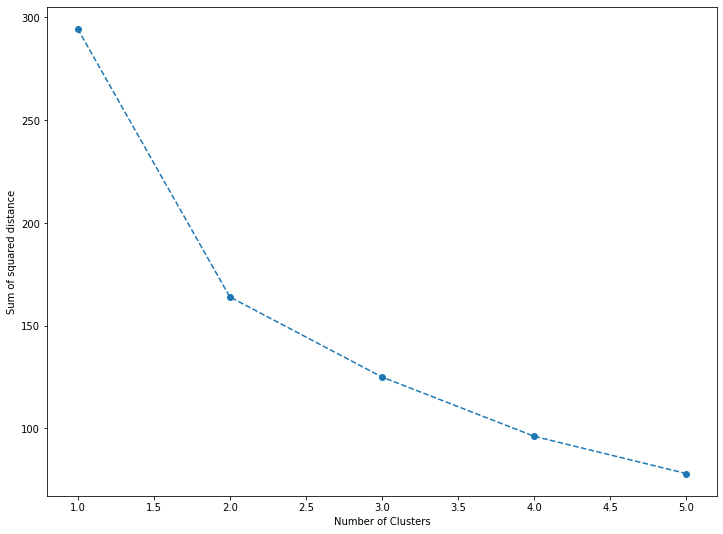

In [174]:
plt.figure(figsize=(12, 9))
plt.plot(index_for_kmeans(results), results, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()



In [175]:
#Using Elbow method, we found the best model for this is 2 
kmeans = KMeans(n_clusters = 3 , init = 'k-means++',random_state = 42 )
kmeans.fit(y)
y = kmeans.labels_

In [176]:
pd.Index( y.tolist()).value_counts()

1    1854
2     935
0     401
dtype: int64

#Classification Modeling

## Random Forest

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [178]:
#splitting the dataset 
X_train, X_test, y_train,y_test= train_test_split(X,y, test_size = 0.2 , random_state = 42, stratify = y )

In [179]:
#Random Forest 

rfc = RandomForestClassifier(random_state = 42 )

#fit to model 
rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)


accuracy_score(y_test, y_pred)


0.9984326018808778

##Cross Validation

In [180]:
cross_val_score(rfc, X_train, y_train, cv=10).mean()

0.9941191789215686

## Create Grid Search

In [181]:
# create the grid
n_estimators = [10, 100, 1000]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [182]:
grid = GridSearchCV(estimator=rfc, 
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


In [183]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993339 using {'max_depth': None, 'n_estimators': 1000}
0.990987 (0.002743) with: {'max_depth': None, 'n_estimators': 10}
0.992947 (0.003918) with: {'max_depth': None, 'n_estimators': 100}
0.993339 (0.004310) with: {'max_depth': None, 'n_estimators': 1000}
0.984718 (0.002743) with: {'max_depth': 5, 'n_estimators': 10}
0.976489 (0.003918) with: {'max_depth': 5, 'n_estimators': 100}
0.983542 (0.001567) with: {'max_depth': 5, 'n_estimators': 1000}
0.992163 (0.003135) with: {'max_depth': 10, 'n_estimators': 10}
0.992947 (0.003918) with: {'max_depth': 10, 'n_estimators': 100}
0.992947 (0.004702) with: {'max_depth': 10, 'n_estimators': 1000}
0.990987 (0.002743) with: {'max_depth': 20, 'n_estimators': 10}
0.992947 (0.003918) with: {'max_depth': 20, 'n_estimators': 100}
0.993339 (0.004310) with: {'max_depth': 20, 'n_estimators': 1000}
